In [110]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import ydata_profiling as profiler

np.random.seed(0)

In [111]:
raw_data = pd.read_csv("data/train.csv")

Item_Identifier ---- Unique product ID

Item_Weight ---- Weight of product

Item_Fat_Content ---- Whether the product is low fat or not

Item_Visibility ---- The % of the total display area of all products in a store allocated to the particular product

Item_Type ---- The category to which the product belongs

Item_MRP ---- Maximum Retail Price (list price) of the product

Outlet_Identifier ---- Unique store ID

Outlet_Establishment_Year ---- The year in which the store was established

Outlet_Size ---- The size of the store in terms of ground area covered

Outlet_Location_Type ---- The type of city in which the store is located

*Outlet_Type ---- Whether the outlet is just a grocery store or some sort of supermarket

Item_Outlet_Sales ---- sales of the product in t particular store. This is the outcome variable to be predicted.


# Data Exploring

In [112]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Dealing with missing

In [113]:
raw_data.isnull().sum().sort_values()

Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_Weight                  1463
Outlet_Size                  2410
dtype: int64

In [114]:
raw_data[~raw_data.isin(raw_data.dropna())].groupby(['Outlet_Identifier']).count()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Outlet_Identifier,,,,,,,,,,,
OUT010,555,555,555,555,555,555,555,0,555,555,555
OUT017,926,926,926,926,926,926,926,0,926,926,926
OUT019,528,0,528,528,528,528,528,528,528,528,528
OUT027,935,0,935,935,935,935,935,935,935,935,935
OUT045,929,929,929,929,929,929,929,0,929,929,929


### Outlet size

In [115]:
missing = raw_data.loc[raw_data['Outlet_Size'].notna() == False]
present = raw_data.loc[raw_data['Outlet_Size'].notna() == True]

In [116]:
missing.groupby(['Outlet_Identifier']).count()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Outlet_Identifier,,,,,,,,,,,
OUT010,555,555,555,555,555,555,555,0,555,555,555
OUT017,926,926,926,926,926,926,926,0,926,926,926
OUT045,929,929,929,929,929,929,929,0,929,929,929


Outlet size is completely missing on every occurrence in [OUT010, OUT017 and OUT045]

Filling by new category

In [117]:
raw_data.Outlet_Size.unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [118]:
raw_data.Outlet_Size = raw_data.Outlet_Size.fillna('undefined')

In [119]:
raw_data.Outlet_Size.unique()

array(['Medium', 'undefined', 'High', 'Small'], dtype=object)

### Item weight

In [120]:
missing = raw_data.loc[raw_data['Item_Weight'].notna() == False]
present = raw_data.loc[raw_data['Item_Weight'].notna() == True]

In [121]:
missing.Item_Identifier.unique()

array(['FDP10', 'DRI11', 'FDW12', ..., 'FDQ58', 'DRG13', 'NCN18'],
      dtype=object)

Searching for records from other outlets and filling where it is possible.

In [122]:
for id in missing.Item_Identifier.unique():
    found_row = raw_data.query(f'Item_Identifier == "{id}"')
    found_row = found_row[found_row['Item_Weight'].isna() == False]
    filler_weight = found_row.Item_Weight.median()
    raw_data.loc[raw_data['Item_Identifier'] == id] = raw_data.loc[raw_data['Item_Identifier'] == id].fillna(filler_weight)

In [123]:
still_missing = raw_data.loc[raw_data['Item_Weight'].isna()].Item_Identifier.unique()
still_missing

array(['FDN52', 'FDK57', 'FDE52', 'FDQ60'], dtype=object)

Filling the no-clues ones

In [124]:
median_weight_by_type = raw_data.loc[:, ['Item_Weight', 'Item_Type']].groupby('Item_Type').median()
median_weight_by_type

,Item_Weight
Item_Type,
Baking Goods,11.6500
Breads,10.6000
Breakfast,10.6950
Canned,12.3500
Dairy,13.3500
Frozen Foods,12.8500
Fruits and Vegetables,13.1000
Hard Drinks,9.8975
Health and Hygiene,12.1500


In [125]:
for id in still_missing:
    missing_element = raw_data.loc[raw_data['Item_Identifier'] == id]
    new_weight = median_weight_by_type.loc[missing_element.Item_Type.iloc[0]].iloc[0]
    raw_data.loc[raw_data['Item_Identifier'] == id] = raw_data.loc[raw_data['Item_Identifier'] == id].fillna(new_weight)

In [126]:
raw_data.loc[raw_data['Item_Weight'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [127]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### So, data is full now

## Dealing with categorical & numerical

### Separating columns

In [128]:
raw_data.dtypes.sort_values()

Outlet_Establishment_Year      int64
Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Identifier               object
Item_Fat_Content              object
Item_Type                     object
Outlet_Identifier             object
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
dtype: object

<!-- Lets turn Outlet_Establishment_Year into categorical -->

In [129]:
# raw_data.Outlet_Establishment_Year = raw_data.Outlet_Establishment_Year.astype(object)

In [130]:
numerical_columns = raw_data.select_dtypes(include=['int64', 'float64']).columns.to_list()
categorical_columns = raw_data.select_dtypes(include='object').columns.to_list()
print(f'Numerical columns: {numerical_columns}')
print(f'Categorical columns: {categorical_columns}')

Numerical columns: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
Categorical columns: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


### Finding categorical & encoding

In [131]:
for col in categorical_columns:
    print(raw_data.loc[:, col].unique())

['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['Medium' 'undefined' 'High' 'Small']
['Tier 1' 'Tier 3' 'Tier 2']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


So, there are IDs and categories. Lets rename some categories for more neat view

In [132]:
raw_data.replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'}, inplace=True)
raw_data.replace({'Tier 1': '1', 'Tier 2': '2', 'Tier 3': '3'}, inplace=True)
raw_data.replace({'Supermarket Type1': 'S1', 'Supermarket Type2': 'S2', 'Supermarket Type3': 'S3', 'Grocery Store': 'G'}, inplace=True)

In [133]:
for col in categorical_columns:
    print(raw_data.loc[:, col].unique())

['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
['Low Fat' 'Regular']
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['Medium' 'undefined' 'High' 'Small']
['1' '3' '2']
['S1' 'S2' 'G' 'S3']


In [134]:
raw_data.select_dtypes('object').nunique().sort_values(ascending=False)

Item_Identifier         1559
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                4
Outlet_Type                4
Outlet_Location_Type       3
Item_Fat_Content           2
dtype: int64

In [135]:
categorical_columns_to_display = [elem for elem in categorical_columns if raw_data[elem].nunique() <= 20]
categorical_columns_to_display

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

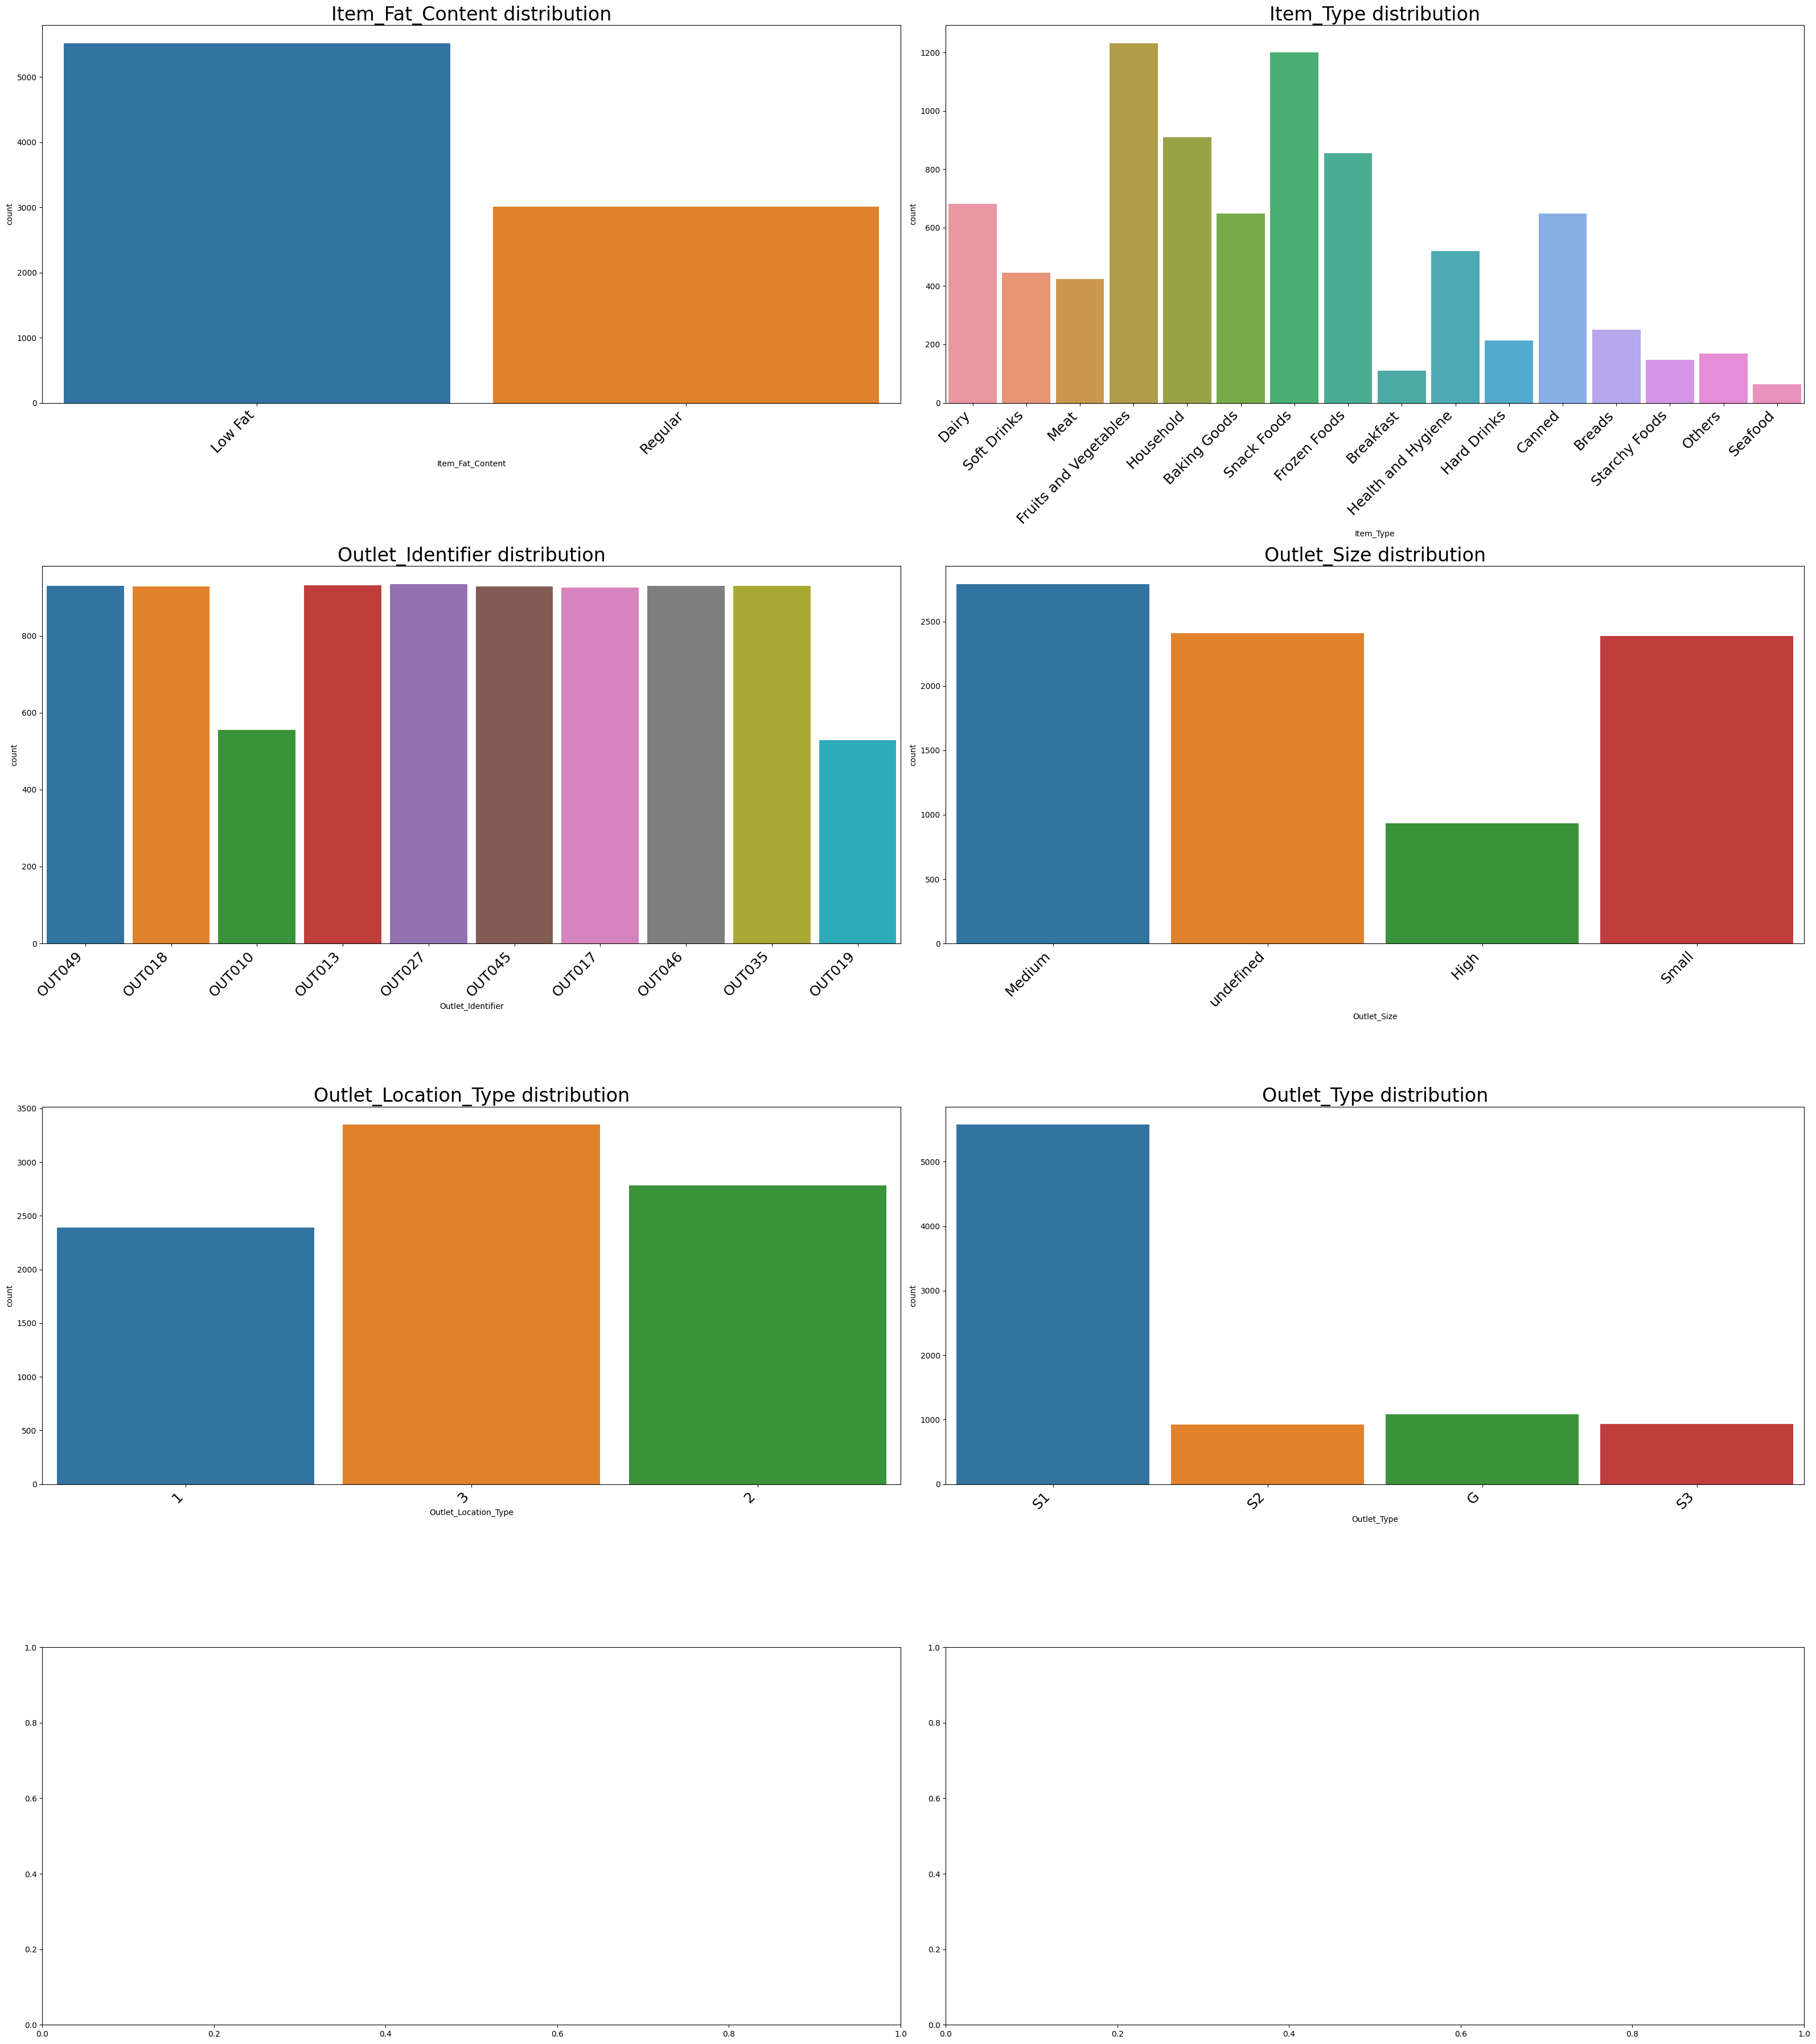

In [136]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(categorical_columns_to_display):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=raw_data, x=col , ax=ax[r][c], width=0.9)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

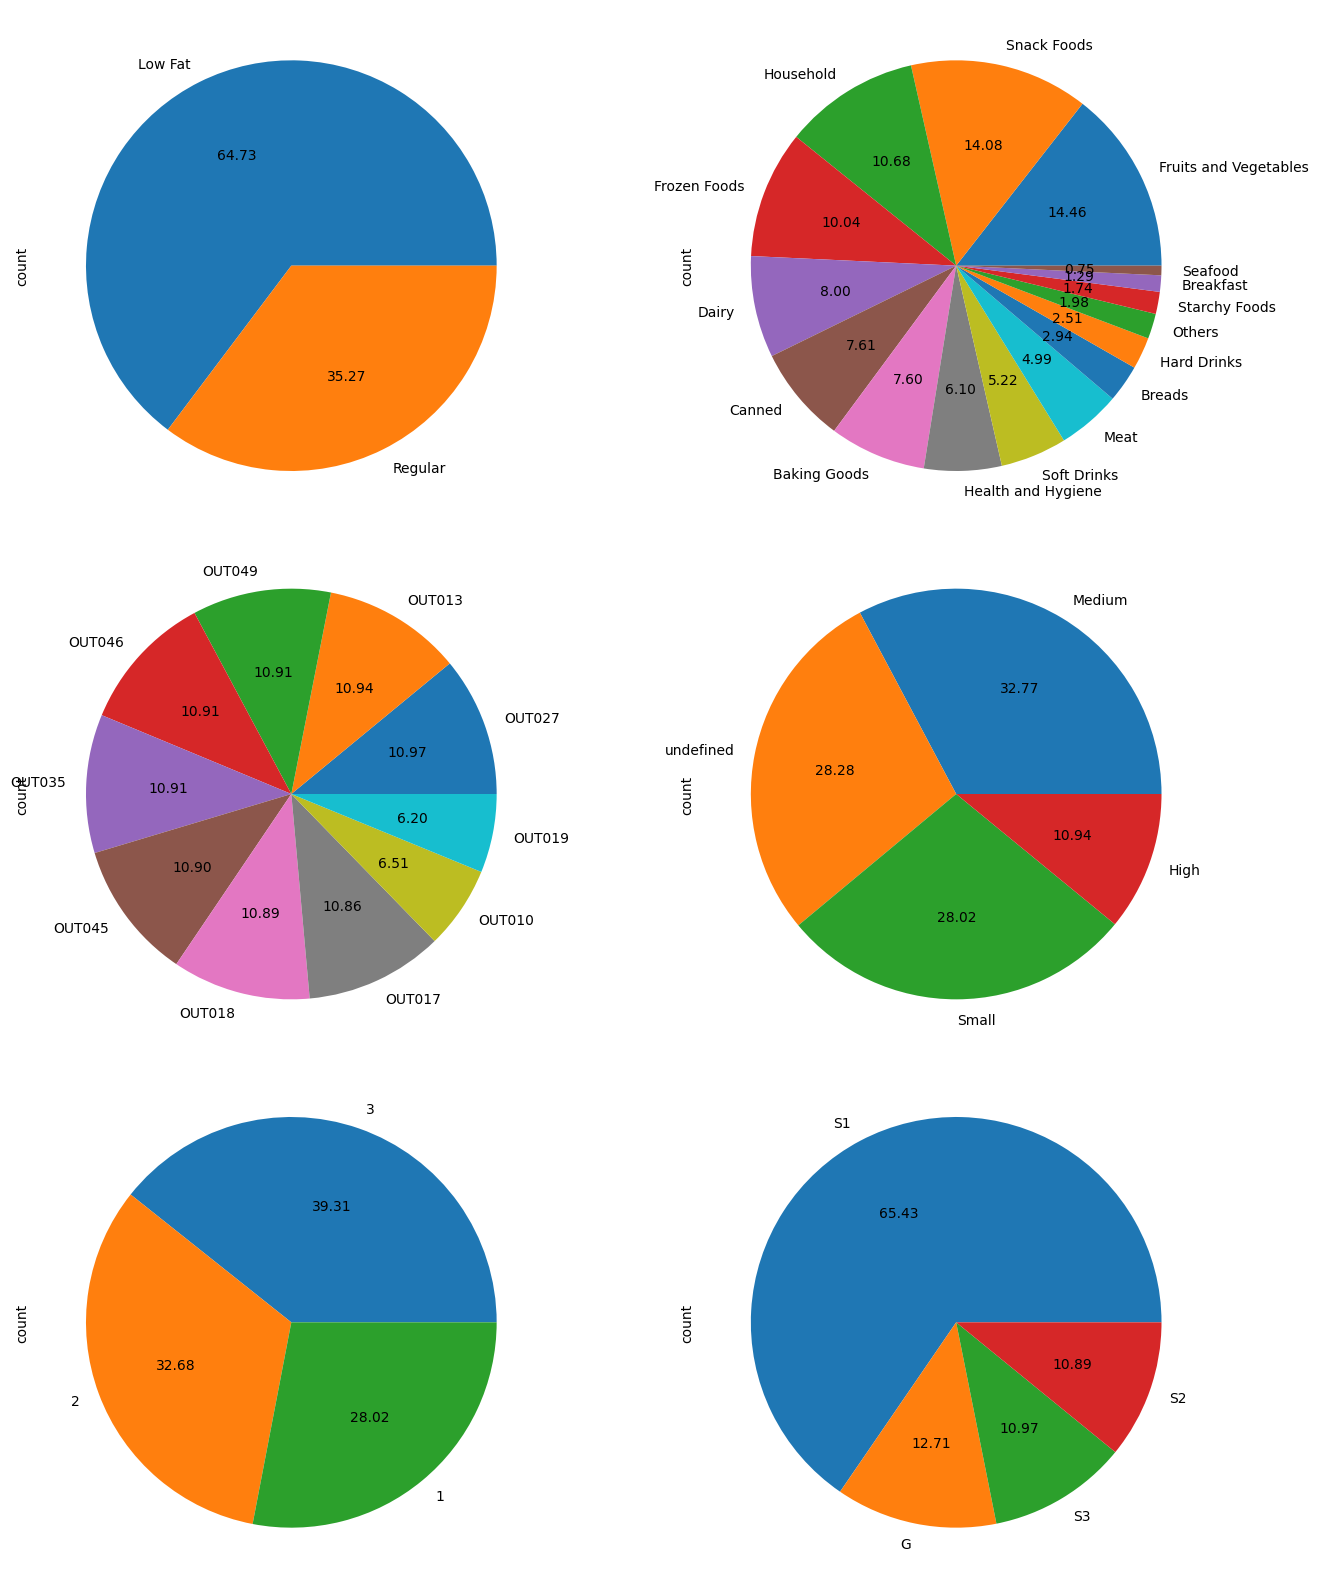

In [146]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for index, col in enumerate(categorical_columns_to_display):
    r = index // 2
    c = index % 2
    raw_data[col].value_counts().plot(kind="pie", autopct="%.2f", ax=ax[r][c])
    #g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    #ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

### Taking view into numerical values

In [137]:
raw_data.describe().round(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000,8523.000,8523.000,8523.000,8523.000
mean,12.875,0.066,140.993,1997.832,2181.289
std,4.645,0.052,62.275,8.372,1706.500
min,4.555,0.000,31.290,1985.000,33.290
25%,8.785,0.027,93.826,1987.000,834.247
50%,12.650,0.054,143.013,1999.000,1794.331
75%,16.850,0.095,185.644,2004.000,3101.296
max,21.350,0.328,266.888,2009.000,13086.965


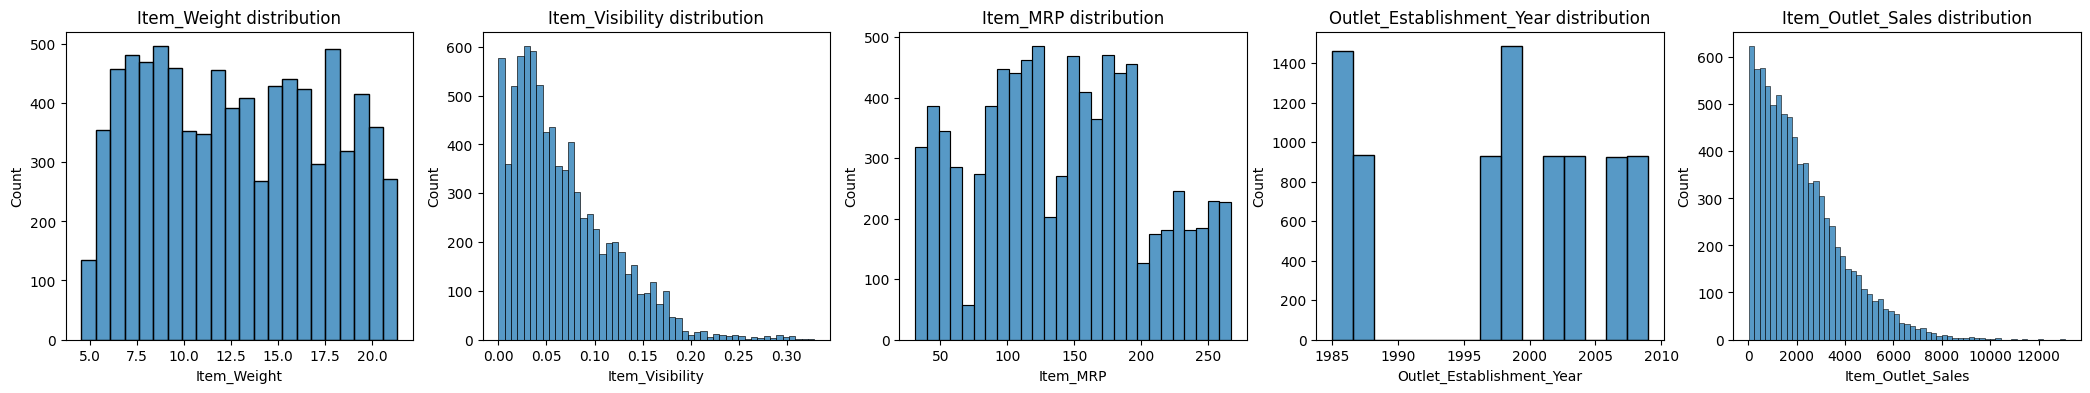

In [139]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numerical_columns):
    sns.histplot(raw_data[col], kde=False, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

/// Possible outliers

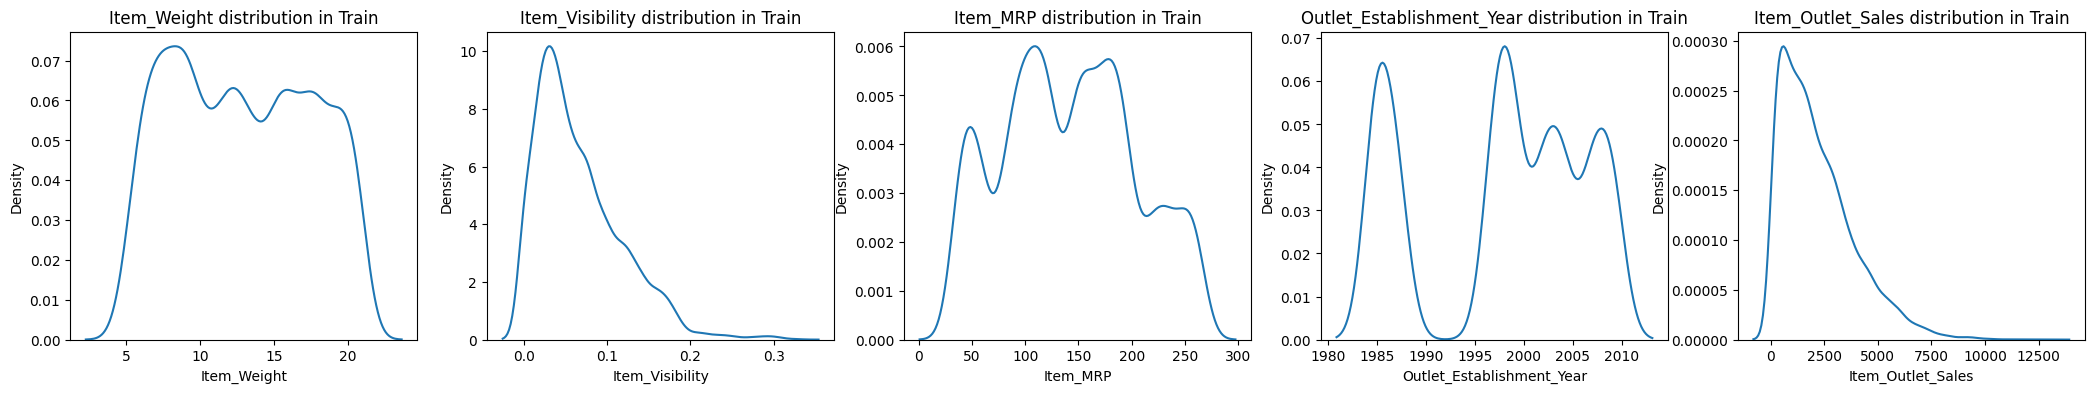

In [140]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numerical_columns):
    sns.kdeplot(data=raw_data, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Train')

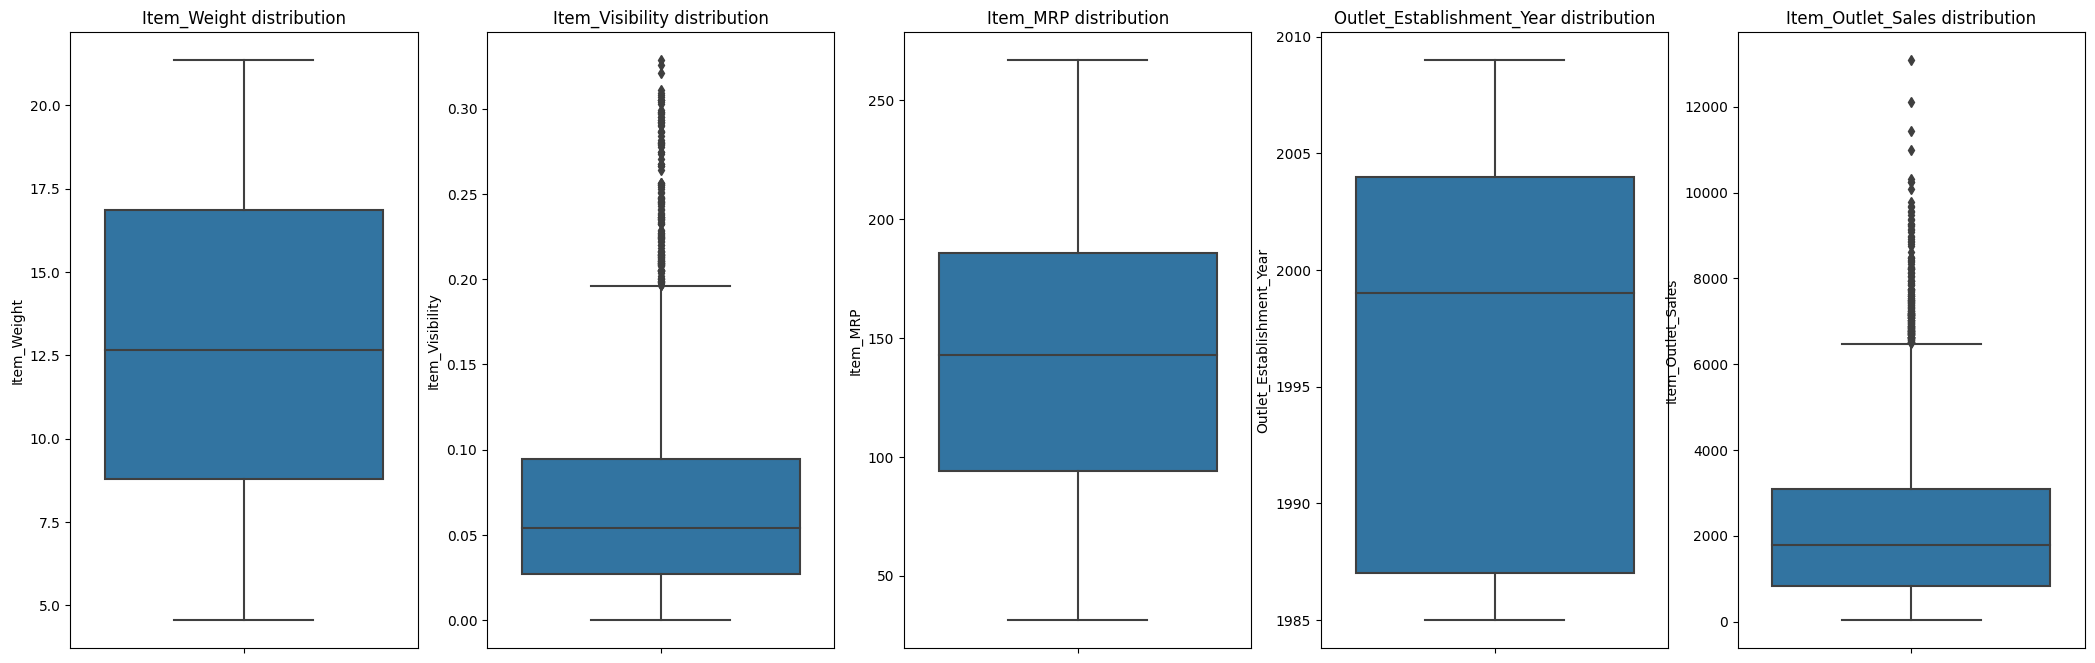

In [142]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numerical_columns):
    sns.boxplot(data=raw_data, y=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

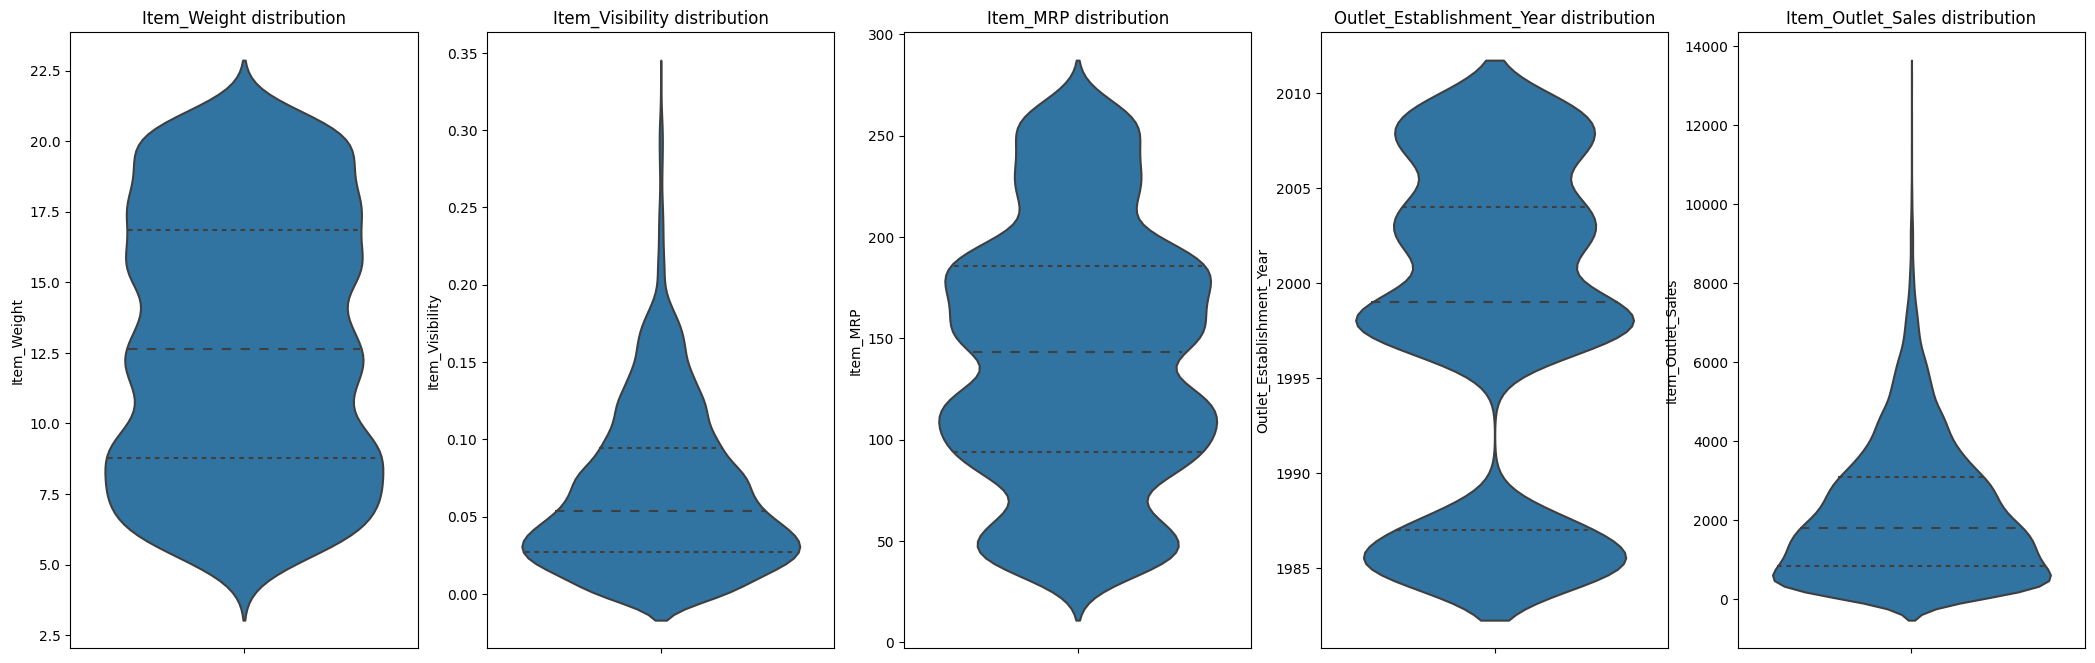

In [144]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numerical_columns):
    sns.violinplot(data=raw_data, y=col, ax=ax[index], inner='quartile')
    ax[index].set_title(f'{col} distribution')

## Generating auto-profiler

In [ ]:
# prof = profiler.ProfileReport(raw_data, title='Raw Data')
# prof.to_notebook_iframe()

## Analysis

In [ ]:
data = raw_data[['Outlet_Identifier', 'Item_Identifier', 'Item_Outlet_Sales', 'Item_Visibility', 'Item_MRP', 'Item_Weight', 'Item_Type', 'Item_Fat_Content', 'Outlet_Establishment_Year', 'Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type']]

In [ ]:
goods = data[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales', 'Item_Visibility', 'Item_MRP', 'Item_Weight', 'Item_Type', 'Item_Fat_Content']].sort_values('Item_Identifier')

In [ ]:
outlets = data[['Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type']].groupby("Outlet_Identifier").first()
outlets

,Outlet_Establishment_Year,Outlet_Type,Outlet_Size,Outlet_Location_Type
Outlet_Identifier,,,,
OUT010,1998,Grocery Store,undefined,Tier 3
OUT013,1987,Supermarket Type1,High,Tier 3
OUT017,2007,Supermarket Type1,undefined,Tier 2
OUT018,2009,Supermarket Type2,Medium,Tier 3
OUT019,1985,Grocery Store,Small,Tier 1
OUT027,1985,Supermarket Type3,Medium,Tier 3
OUT035,2004,Supermarket Type1,Small,Tier 2
OUT045,2002,Supermarket Type1,undefined,Tier 2
OUT046,1997,Supermarket Type1,Small,Tier 1


In [ ]:
def get_outlet_info(key):
    return goods.loc[goods['Outlet_Identifier'] == key].drop(['Outlet_Identifier'], axis=1).sort_index()

In [ ]:
get_outlet_info('OUT049')

,Item_Identifier,Item_Outlet_Sales,Item_Visibility,Item_MRP,Item_Weight,Item_Type,Item_Fat_Content
0,FDA15,3735.1380,0.016047,249.8092,9.300,Dairy,Low Fat
2,FDN15,2097.2700,0.016760,141.6180,17.500,Meat,Low Fat
10,FDY07,1516.0266,0.000000,45.5402,11.800,Fruits and Vegetables,Low Fat
12,FDX32,1589.2646,0.100014,145.4786,15.100,Fruits and Vegetables,Regular
17,FDP49,718.3982,0.069196,54.3614,9.000,Breakfast,Regular
...,...,...,...,...,...,...,...
8451,FDK21,3254.4304,0.010028,249.6408,7.905,Snack Foods,Low Fat
8467,FDV31,3881.6140,0.000000,175.2370,9.800,Fruits and Vegetables,Low Fat
8470,FDW27,1551.3140,0.151088,155.1314,5.860,Meat,Regular
8475,NCS17,378.1744,0.080627,92.5436,18.600,Health and Hygiene,Low Fat
